Mean Squared Error: 5.783070875506389


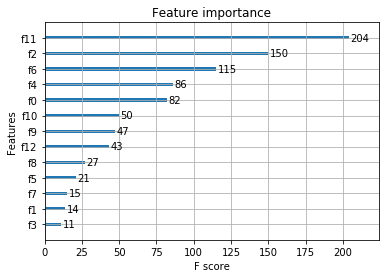

In [141]:
'''
Created 2018-10-27
XGBoost Algorithm on predicting time
Author: ZHANG Yuning
'''
#!/usr/bin/python
# coding:utf8

import numpy as np
import pandas as pd
import sklearn.feature_selection
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.decomposition import PCA 

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#from __future__ import print_function
#计算分类的正确率
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import scale
from xgboost import plot_importance


def loadcsv():
    df = pd.read_csv('train.csv')
    dftrain = pd.read_csv('train.csv',usecols=[1,3,4,6,7,8,9,10,11,12,13])
    #print(dftrain.head())
    dflabel= pd.read_csv('train.csv',usecols=[14])
    #print(dflabel.head())
    df2 = pd.read_csv('test.csv')
    dftest=pd.read_csv('test.csv',usecols=[1,3,4,6,7,8,9,10,11,12,13])
    #print(dftest.head())
    return dftrain,dftest,dflabel,df2

def preprocess(dftrain,dftest):
    #对以下变量进行labelEncoder编码
    dftrain['penalty']=dftrain['penalty'].replace('none',0)
    dftrain['penalty']=dftrain['penalty'].replace('l2',1)
    dftrain['penalty']=dftrain['penalty'].replace('elasticnet',2)
    dftrain['penalty']=dftrain['penalty'].replace('l1',3)
    dftest['penalty']=dftest['penalty'].replace('none',0)
    dftest['penalty']=dftest['penalty'].replace('l2',1)
    dftest['penalty']=dftest['penalty'].replace('elasticnet',2)
    dftest['penalty']=dftest['penalty'].replace('l1',3)
    dftrain['new1']=dftrain['n_samples']*dftrain['n_features']/dftrain['n_jobs']
    dftest['new1']=dftest['n_samples']*dftest['n_features']/dftest['n_jobs']
    dftrain['new2']=dftrain['n_samples']*dftrain['n_features']
    dftest['new2']=dftest['n_samples']*dftest['n_features']
    dftrain=pd.DataFrame(dftrain)
    #print(dftrain.head())
    dftest=pd.DataFrame(dftest)
    #rint(dftest.head())
    return dftrain,dftest

def featureSet(df): 
    df['alpha'] = -(np.log10(df['alpha']))
    df['n_jobs'] = df['n_jobs'].replace(-1,max(df['n_jobs']))
    return df


def trainXGBoost(dftrain,dftest,dflabel,df2):
    
    x_train,x_test,y_train,y_test=train_test_split(dftrain.values, dflabel.values, test_size=0.15,random_state=66)
    df=pd.DataFrame(x_train)
    #print(df.head())
    #print(dftest.head())
    XGB = XGBRegressor(silent=1 ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
                       #booster='gblinear',#采用线性模型进行提升计算，默认是gbtree
                       learning_rate=0.2, # 如同学习率
                        min_child_weight=1, 
                        # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                        #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                        #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
                        max_depth=4, # 构建树的深度，越大越容易过拟合
                        gamma=0.2,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
                        subsample=1, # 随机采样训练样本 训练实例的子采样比
                        max_delta_step=1,#最大增量步长，我们允许每个树的权重估计。
                        colsample_bytree=1, # 生成树时进行的列采样 
                        reg_lambda=6,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                        reg_alpha=0, # L1 正则项参数
                        scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
                        n_estimators=360, #树的个数
                        seed=60 #随机种子
                      )
    XGB.fit(x_train,y_train,eval_metric='rmse',verbose=False)
    y_true, y_pred = y_test, XGB.predict(x_test)
    ans=XGB.predict(dftest.values)
    
    for t in range(len(dftest)):
        if ans[t]<=0:
            ans[t]=min(dflabel.values)
         
    submission_df = pd.DataFrame(data = {'Id':df2.id,'time':ans})
    submission_df.to_csv('submission.csv',index=None)

    #print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))  
    #print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    
    plot_importance(XGB)
    plt.show()

 

    
if __name__ == "__main__":
    dftrain,dftest,dflabel,df2 = loadcsv()
    dftrain=featureSet(dftrain)
    dftest=featureSet(dftest)
    dftrain,dftest=preprocess(dftrain,dftest)
    trainXGBoost(dftrain,dftest,dflabel,df2)
    


Start cross validation
[0]	train-rmse:3.39342+0.0802123	test-rmse:3.60703+1.40705
[1]	train-rmse:2.21577+0.0653955	test-rmse:3.22079+1.30768
[2]	train-rmse:1.62171+0.0681582	test-rmse:3.12383+1.15666
[3]	train-rmse:1.29212+0.0910399	test-rmse:3.08931+1.09171
[4]	train-rmse:1.05883+0.0857713	test-rmse:3.075+1.04284
[5]	train-rmse:0.863911+0.073458	test-rmse:3.05183+1.05258
Best number of trees = 6
Fit on the trainingsdata
Mean Squared Error: 0.6944999776200518


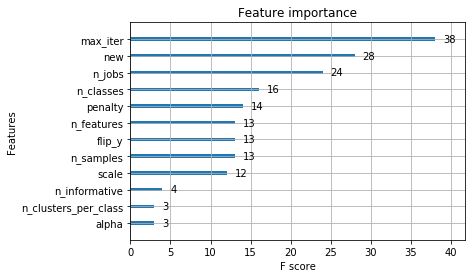

In [10]:
'''
Created 2018-10-27
XGBoost Algorithm on predicting time
Author: ZHANG Yuning
'''
#!/usr/bin/python
# coding:utf8

import numpy as np
import pandas as pd
import sklearn.feature_selection
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.decomposition import PCA 

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#from __future__ import print_function
#计算分类的正确率
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import scale
from xgboost import plot_importance


def loadcsv():
    df = pd.read_csv('train.csv')
    dftrain = pd.read_csv('train.csv',usecols=[1,3,4,6,7,8,9,10,11,12,13])
    #print(dftrain.head())
    dflabel= pd.read_csv('train.csv',usecols=[14])
    #print(dflabel.head())
    df2 = pd.read_csv('test.csv')
    dftest=pd.read_csv('test.csv',usecols=[1,3,4,6,7,8,9,10,11,12,13])
    #print(dftest.head())
    return dftrain,dftest,dflabel,df2

def preprocess(dftrain,dftest):
    dftrain['penalty']=dftrain['penalty'].replace('none',0)
    dftrain['penalty']=dftrain['penalty'].replace('l2',1)
    dftrain['penalty']=dftrain['penalty'].replace('elasticnet',2)
    dftrain['penalty']=dftrain['penalty'].replace('l1',3)
    dftest['penalty']=dftest['penalty'].replace('none',0)
    dftest['penalty']=dftest['penalty'].replace('l2',1)
    dftest['penalty']=dftest['penalty'].replace('elasticnet',2)
    dftest['penalty']=dftest['penalty'].replace('l1',3)
    dftrain['new']=dftrain['n_samples']*dftrain['n_features']
    dftest['new']=dftest['n_samples']*dftest['n_features']
    #pca=PCA(n_components=11)
    #dftrain=pca.fit_transform(dftrain)
    #dftest=pca.transform(dftest)
    #dftrain = scale(dftrain)
    #dftest = scale(dftest)
    dftrain=pd.DataFrame(dftrain)
    #print(dftrain.head())
    dftest=pd.DataFrame(dftest)
    #rint(dftest.head())
    return dftrain,dftest

def featureSet(df): 
    #Removing features with low variance（剔除低方差的特征）
    #Univariate feature selection（单变量特征选择）
    #Recursive feature elimination（递归功能消除）
    #Feature selection using SelectFromModel（使用SelectFromModel进行特征选择）
    df['alpha'] = -(np.log10(df['alpha']))
    #df['n_samples']=np.log1p(df['n_samples'])
    #df['n_features']=np.log1p(df['n_features'])
    #df['max_iter']=np.log1p(df['max_iter'])
    #df['random_state'] = np.log1p(df['random_state'])
    #df['flip_y']=df['flip_y']*100
    #df['l1_ratio']=df['l1_ratio']*10
    #df['scale']=df['scale']/10
    #df['n_classes']=df['n_classes']*df['n_clusters_per_class']
    #rint(df.head())
    return df


def trainXGBoost(dftrain,dftest,dflabel,df2):
    dtrain = xgb.DMatrix(dftrain, dflabel)
    clf = XGBRegressor(silent=1 ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
                       #booster='gblinear',#采用线性模型进行提升计算，默认是gbtree
                       binary='logistic'     #概率 
                       learning_rate= 0.9, # 如同学习率
                       min_child_weight=1, 
                       # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                       #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                       #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
                       max_depth=6, # 构建树的深度，越大越容易过拟合
                       gamma=0.6,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
                       subsample=1, # 随机采样训练样本 训练实例的子采样比
                       max_delta_step=1,#最大增量步长，我们允许每个树的权重估计。
                       colsample_bytree=1, # 生成树时进行的列采样 
                       reg_lambda=6,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                       reg_alpha=0, # L1 正则项参数
                       scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
                       n_estimators=180, #树的个数
                       seed=60 #随机种子
                      )
    xgb_param = clf.get_xgb_params()
    #do cross validation
    print ('Start cross validation')
    cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=6, nfold=15, metrics=['rmse'],
                     seed=0, callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
    print('Best number of trees = {}'.format(cvresult.shape[0]))
    clf.set_params(n_estimators=cvresult.shape[0])
    print('Fit on the trainingsdata')
    clf.fit(dftrain, dflabel, eval_metric='rmse')
    print('Mean Squared Error:', metrics.mean_squared_error(dflabel, clf.predict(dftrain)))
    #print('Predict the probabilities based on features in the test set')
    ans = clf.predict(dftest, ntree_limit=cvresult.shape[0])
    for t in range(len(dftest)):
        if ans[t]<=0:
            #ans[t]=min(dflabel.values)
            ans[t]=0
         
    submission_df = pd.DataFrame(data = {'Id':df2.id,'time':ans})
    submission_df.to_csv('submission.csv',index=None) 
    # 显示重要特征
    plot_importance(clf)
    plt.show()

    
if __name__ == "__main__":
    dftrain,dftest,dflabel,df2 = loadcsv()
    dftrain=featureSet(dftrain)
    dftest=featureSet(dftest)

    dftrain,dftest=preprocess(dftrain,dftest)
    trainXGBoost(dftrain,dftest,dflabel,df2)
    


Start cross validation
[0]	train-rmse:3.9087+0.0674268	test-rmse:3.81459+1.89746
[1]	train-rmse:2.84859+0.0522129	test-rmse:3.29977+1.63188
[2]	train-rmse:2.14108+0.0380386	test-rmse:3.16657+1.52552
[3]	train-rmse:1.69623+0.0358443	test-rmse:3.03957+1.48927
[4]	train-rmse:1.3821+0.0354869	test-rmse:3.01496+1.3702
[5]	train-rmse:1.14476+0.0278675	test-rmse:2.98365+1.27708
Best number of trees = 6
Fit on the trainingsdata
Mean Squared Error: 1.3538279630671832


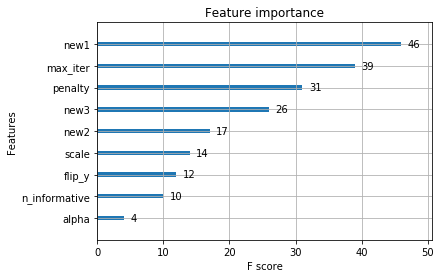

In [25]:
'''
Created 2018-10-27
XGBoost Algorithm on predicting time
Author: ZHANG Yuning
'''
#!/usr/bin/python
# coding:utf8

import numpy as np
import pandas as pd
import sklearn.feature_selection
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.decomposition import PCA 

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#from __future__ import print_function
#计算分类的正确率
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import scale
from xgboost import plot_importance


def loadcsv():
    df = pd.read_csv('train.csv')
    dftrain = pd.read_csv('train.csv',usecols=[1,3,4,6,7,8,9,10,11,12,13])
    #print(dftrain.head())
    dflabel= pd.read_csv('train.csv',usecols=[14])
    #print(dflabel.head())
    df2 = pd.read_csv('test.csv')
    dftest=pd.read_csv('test.csv',usecols=[1,3,4,6,7,8,9,10,11,12,13])
    #print(dftest.head())
    return dftrain,dftest,dflabel,df2

def preprocess(dftrain,dftest):
    dftrain['penalty']=dftrain['penalty'].replace('none',0)
    dftrain['penalty']=dftrain['penalty'].replace('l2',1)
    dftrain['penalty']=dftrain['penalty'].replace('elasticnet',2)
    dftrain['penalty']=dftrain['penalty'].replace('l1',3)
    dftest['penalty']=dftest['penalty'].replace('none',0)
    dftest['penalty']=dftest['penalty'].replace('l2',1)
    dftest['penalty']=dftest['penalty'].replace('elasticnet',2)
    dftest['penalty']=dftest['penalty'].replace('l1',3)
    dftrain['new1']=dftrain['n_samples']*dftrain['n_features']/dftrain['n_jobs']
    dftest['new1']=dftest['n_samples']*dftest['n_features']/dftest['n_jobs']
    dftrain['new2']=dftrain['n_samples']*dftrain['n_features']
    dftest['new2']=dftest['n_samples']*dftest['n_features']
    dftrain['new3']=dftrain['n_classes']*dftrain['n_clusters_per_class']
    dftest['new3']=dftest['n_classes']*dftest['n_clusters_per_class']
    #dftrain=dftrain.drop(columns=['n_jobs'])
    #dftest=dftest.drop(columns=['n_jobs'])
    dftrain=dftrain.drop(columns=['n_samples','n_features','n_jobs','n_classes','n_clusters_per_class'])
    dftest=dftest.drop(columns=['n_samples','n_features','n_jobs','n_classes','n_clusters_per_class'])
    dftrain=pd.DataFrame(dftrain)
    #print(dftrain.head())
    dftest=pd.DataFrame(dftest)
    return dftrain,dftest

def featureSet(df): 
    df['n_jobs'] = df['n_jobs'].replace(-1,max(df['n_jobs']))
    df['alpha'] = -(np.log10(df['alpha']))
    return df


def trainXGBoost(dftrain,dftest,dflabel,df2):
    dtrain = xgb.DMatrix(dftrain, dflabel)
    clf = XGBRegressor(silent=1 ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
                       #booster='gblinear',#采用线性模型进行提升计算，默认是gbtree
                       learning_rate= 0.6, # 如同学习率
                       min_child_weight=1, 
                       # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
                       #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
                       #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
                       max_depth=6, # 构建树的深度，越大越容易过拟合
                       gamma=0.2,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
                       subsample=1, # 随机采样训练样本 训练实例的子采样比
                       max_delta_step=0,#最大增量步长，我们允许每个树的权重估计。
                       colsample_bytree=1, # 生成树时进行的列采样 
                       reg_lambda=6,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
                       reg_alpha=0, # L1 正则项参数
                       scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
                       n_estimators=180, #树的个数
                       seed=60 #随机种子
                      )
    
    xgb_param = clf.get_xgb_params()
    #do cross validation
    print ('Start cross validation')
    cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=6, nfold=15, metrics=['rmse'],
                     seed=0, callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
    print('Best number of trees = {}'.format(cvresult.shape[0]))
    clf.set_params(n_estimators=cvresult.shape[0])
    print('Fit on the trainingsdata')
    clf.fit(dftrain, dflabel, eval_metric='rmse')
    print('Mean Squared Error:', metrics.mean_squared_error(dflabel, clf.predict(dftrain)))
    #print('Predict the probabilities based on features in the test set')
    ans = clf.predict(dftest, ntree_limit=cvresult.shape[0])
    for t in range(len(dftest)):
        if ans[t]<=0:
            #ans[t]=min(dflabel.values)
            ans[t]=0
         
    submission_df = pd.DataFrame(data = {'Id':df2.id,'time':ans})
    submission_df.to_csv('submission.csv',index=None) 
    # 显示重要特征
    plot_importance(clf)
    plt.show()

    
if __name__ == "__main__":
    dftrain,dftest,dflabel,df2 = loadcsv()
    dftrain=featureSet(dftrain)
    dftest=featureSet(dftest)

    dftrain,dftest=preprocess(dftrain,dftest)
    trainXGBoost(dftrain,dftest,dflabel,df2)
    